## Contents


### Extract, Transform, Load the Data
Step 1<br>
If the run date is not a business day, the user can but does not have to, skip to step 7 instead<br>
<a href='#run-api-download'>Run the API stock data download and clean</a><br>


Step 2<br>
<a href='#Transform-API-data'>Run the Transform of API data</a><br>

Step 3<br>
<a href='#Save-dataframe-to-CSV'>Save data to CSV files</a><br>

Step 4<br>
<a href='#Set-database-credentials'>Set database credentials</a><br></a>

Step 5<br>
Query the database to make sure both stock_cleaned and stock_transformed database tables exist and are populated<br>
<a href='#Database queries'>Database queries</a><br>

Step 6<br>
Upload the cleaned and the transformed data to the database, if the run date IS a business day with new price data to add<br>
<a href='#Upload-stock-data'>Upload stock data</a><br>

Step 7<br>
If the run date is NOT a business day with new stock prices, then you can, but don't need to, retrieve the stock_cleaned and stock_transformed data from the database instead<br>
<a href='#download-db-data'>Download DB data</a><br>


### Results of Data Analysis<br>

Definitions and function definitions for event tests<br>
<a href='#Event_Tests'>Event_Tests</a><br>

Tweet tests and graphs from our test sample<br>
<a href='#tweet-tests-graphs'>Sample tweets test and graphs</a>

Summary of test statistics<br>
<a href='#test-summary-table'>Test statistics summary table</a>

Test Twitter and Reddit Sentiment Polarity<br>
<a href='#test-twitter-reddit'>Twitter and Reddit Sentiment</a>


In [85]:
import csv
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import time
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

#database libraries
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import pandas.io.sql as sqlio


In [4]:
# expand windows to allow scrolling
import IPython
auto_scroll_threshold = 99999
pd.options.display.max_columns = 99999

<a id='Download-API-data'></a>

# Download API data

In [5]:
'''
Alphavantage is a Y-combinator backed start-up providing free and priced premium financial data 
https://www.alphavantage.co/documentation/#
'''
APIKEY="KA3WLMAG53VKX67"

Define the stock for the API download
__TSLA__ is Tesla, __TWTR__ is Twitter

In [7]:
def download_api_data (input_range, download_df):    

    for i in input_range:    
        
        with requests.Session() as s:
            download = s.get(i)
            decoded_content = download.content.decode('utf-8')
            cr = csv.DictReader(decoded_content.splitlines(), #fieldnames=['time','open','high','low','close','volume'],
                        delimiter=',')
            download_data=[row for row in cr]
            
            temp_df=clean_api_download(download_data)
            
            download_df=pd.concat([download_df,temp_df],axis=0)
            
            download_df=download_df.sort_index(axis=0)
            
    return download_df  

In [8]:
def api_data(input_df):
    
    # This function provides a wrapper to set up the API calls 
    # and adds delays to manage the API call limit of 5 per minute
    # download_api_data() extracts the data
    # clean_api_download() cleans the data
    #
    # Define the dates for the API, going backwards from today
    # Year=1 or 2, month = 1 to 11, each slice is __yearXmonthY__
    
    CSV_URL=[]
    
    year=['year1','year2']
    months=['month1','month2','month3','month4','month5','month6','month7',\
            'month8','month9','month10','month11','month12']
    
    for y in year:
        for m in months:
            CSV_URL.append("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&outputsize=full&" \
             + "apikey="+APIKEY+"&" \
             + "symbol=" + TICKER  + "&" \
             + "interval=1min&" \
             + "slice=" + y + m)   
    
    input_df=download_api_data([CSV_URL[1],CSV_URL[2],CSV_URL[3],CSV_URL[4],CSV_URL[5]],input_df)
    
    time.sleep(60) # waitto avoid making more than 5 calls to the API in a minute
    
    input_df=download_api_data([CSV_URL[6],CSV_URL[7],CSV_URL[8],CSV_URL[9],CSV_URL[10]],input_df)
    
    time.sleep(60) # waitto avoid making more than 5 calls to the API in a minute
    
    input_df=download_api_data([CSV_URL[11]],input_df)
    
    return (input_df)

# Clean the API data
<a id='clean'></a> 


- convert time field to datetime type
- insert it into the dataframe
- set new datetime as the df index
- sort the rows on the datetime values in ascending order
- remove the previoius time field 
- convert all the numbers to float
- insert the ticker as a new column

In [262]:
def clean_api_download(api_df): 
    
    output_df=pd.DataFrame(api_df)
    output_df.dropna()
    time2=pd.to_datetime(output_df['time'])
    output_df.insert(0,column='datetime',value=time2)
    output_df=output_df.set_index('datetime')
    output_df=output_df.drop(labels='time',axis=1)
    
    for i in ['open','high','low','close','volume']:
        output_df[i]=output_df[i].astype('float64')
    
    output_df.insert(0,'ticker',TICKER)
    
    output_df=output_df.sort_index(axis=0)
    
    return output_df

# 1. Run the API download
<a id='run-api-download'></a> 

In [10]:
# dataframe populated with the cleaned API data download.  
# Re-run this definition to drop current value and start download again
api_download_df=pd.DataFrame()
api_download_df=api_data(api_download_df)

In [6]:
TICKER='TWTR'

In [11]:
api_download_df

,ticker,open,high,low,close,volume
datetime,,,,,,
2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0


# Generate Returns, Std Dev, Volume and Range Measures

New fields
- returns by 1min, 30 min, 1h, 1 business day
- volumes add by 30 min, 1 bus day
- ranges by 30 min, 1 b day
- standard deviation by 30 min, 1 bus day
- 30 min standard deviations by time intervals of 30 mins, 1 bus day  
- high to low price range by 1min, 30 mins, 1 bus day

## Simple Returns

This doesn't take account of the date differences, so that return could be open of day 2 v close of day 1

returns_1min= ((stock_df['close'] / stock_df['close'].shift(1)) -1 )

In [12]:
def add_returns_1min(input_df):
    returns_1min= ((input_df['close'] / input_df['close'].shift(1)) -1 ) 
    
    # return for first observation cannot be calculated and 25 Dec and 1 Jan are included in the series from Alphavantage
    
    returns_1min.name='returns_1min'
    input_df=input_df.merge(returns_1min,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    #input_df['ticker']=TICKER
    
    return(input_df)

## 30 min returns

In [13]:
def add_returns_30min(input_df):
    ohlc_30min=input_df['close'].resample("30min",closed='right',label='right').ohlc() # OHLC prices every 30 mins
    
    returns_30min= pd.Series( ohlc_30min['close']/ohlc_30min['close'].shift(1) ) -1
    
    returns_30min.name='returns_30min'
    
    input_df=input_df.merge(returns_30min,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    input_df['ticker']=TICKER
    
    return(input_df)

## 1 day returns

In [14]:
def add_returns_1d(input_df):
    ohlc_1d=input_df['close'].resample("B").ohlc() # OHLC prices every business day
    ohlc_1d=ohlc_1d.dropna() # 25 Dec and 1 Jan are included in the series from Alphavantage
    returns_1d= ( ohlc_1d['close']/ohlc_1d['close'].shift(1) ) -1 # calculate returns from today's close to yesteday's
    returns_1d.name='returns_1d'
    input_df=input_df.merge(returns_1d,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    input_df['ticker']=TICKER
    
    return(input_df)

## 30 minute volumes

In [15]:
def add_volume_30min(input_df):
    
    volume_30min=input_df['volume'].resample("30min",closed='right',label='right').sum() # sum of volume every business day
    
    volume_30min.name='volume_30min'
    
    input_df=input_df.merge(volume_30min,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    input_df['ticker']=TICKER
    
    return(input_df)

## 1 day volume

In [16]:
def add_volume_1d(input_df):
    volume_1d=input_df['volume'].resample("B").sum() # sum of volume every business day
    
    volume_1d.name='volume_1d' # rename the column
    
    input_df=input_df.merge(volume_1d,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    input_df['ticker']=TICKER
    
    return(input_df)

## 30 minute standard deviation

Assuming 252 trading days in the year, we scale up from daily to annualised volatility by multiplying by the square root of 252, as standard e.g. Hull (2009, pp.282--285)

Going from 30 minute windows to annualised volatility takes

In [17]:
#volatility constants

print("sqrt(252)={}".format(np.sqrt(252))) # assuming 252 business days in a year
    
print("sqrt(252*32)={}".format(np.sqrt(252*32))) # assuming 16 hours of trading per business day, or 32 x 30 minute periods
   

sqrt(252)=15.874507866387544
sqrt(252*32)=89.7997772825746


In [18]:
def add_stdev_30min(input_df):
     
    stdev_30min= np.sqrt(252*32)*input_df['returns_1min'].resample("30min",closed='right',label='right').std()
    
    stdev_30min.name='stdev_30min'
    
    input_df['ticker']=TICKER
    
    input_df=input_df.merge(stdev_30min,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    return(input_df)

## 1 day standard deviation

In [19]:
def add_stdev_1d(input_df):
    
    stdev_1d= np.sqrt(252)*input_df['returns_1min'].resample("B",closed='right',label='right').std()
    
    stdev_1d.name='stdev_1d' 
    
    input_df=input_df.merge(stdev_1d,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    input_df['ticker']=TICKER
    
    return(input_df)

## Range 1 min

In [20]:
def add_range_1min(input_df):
    
    high=input_df['high'].resample("1min",closed='right',label='right').max() # OHLC prices every minute max
    low=input_df['low'].resample("1min",closed='right',label='right').min() # OHLC prices every minute min
    
    range_1min=high-low
    
    range_1min=range_1min.dropna() # get rid of the NA for any minute where there is no matching price
    
    range_1min.name='range_1min'
    
    input_df=input_df.merge(range_1min,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    input_df['ticker']=TICKER
    
    return(input_df)

## 30 minute range

In [21]:
def add_range_30min(input_df):
    
    high=input_df['high'].resample("30min",closed='right',label='right').max() # OHLC prices every business day
    
    low=input_df['low'].resample("30min",closed='right',label='right').min() # OHLC prices every business day
    
    range_30min=high-low
    
    range_30min.name='range_30min'
    
    range_30min=range_30min.dropna()
    
    input_df=input_df.merge(range_30min,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    return(input_df)

## Range 1 day

In [22]:
def add_range_1d(input_df):
    
    high=input_df['high'].resample("B",closed='right',label='right').max() # OHLC prices every business day
    
    low=input_df['low'].resample("B",closed='right',label='right').min() # OHLC prices every business day
    
    range_1d=high-low
    
    range_1d.name='range_1d'
    
    range_1d=range_1d.dropna()
    
    input_df=input_df.merge(range_1d,how='outer',left_index=True,right_index=True,sort=True,validate='one_to_one')
    
    return(input_df)

# 2. Run Transform of API data
<a id='Transform-API-data'></a>

Adding the calculated columns

In [23]:
def transform_cleaned_data(input_df):
    
    #add returns columns to the input dataframe
    input_df=add_returns_1min(input_df)
    input_df=add_returns_30min(input_df)
    input_df=add_returns_1d(input_df)

    #add extra volume calculation columns to the input dataframe
    input_df=add_volume_30min(input_df)
    input_df=add_volume_1d(input_df)
    
    #add standard deviations calculation columns to the input dataframe
    input_df=add_stdev_30min(input_df)
    input_df=add_stdev_1d(input_df)
    
    #add range columns to the input dataframe
    input_df=add_range_1min(input_df)
    input_df=add_range_30min(input_df) 
    input_df=add_range_1d(input_df) 
    
    return(input_df)

In [24]:
stock_df=transform_cleaned_data(api_download_df)

## Compare visually the cleaned API download to the transformed data in stock_df

In [25]:
api_download_df

,ticker,open,high,low,close,volume
datetime,,,,,,
2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0


In [26]:
stock_df

,ticker,open,high,low,close,volume,returns_1min,returns_30min,returns_1d,volume_30min,volume_1d,stdev_30min,stdev_1d,range_1min,range_30min,range_1d
datetime,,,,,,,,,,,,,,,,
2021-12-17 00:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18928019.0,NaN,0.0277,NaN,NaN,2.4001
2021-12-17 00:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 02:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0,0.000186,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN


# 3. Save dataframe to CSV files
<a id='Save-dataframe-to-CSV'></a>

In [30]:
def save_df(dataframe,filename):
    from datetime import datetime
    current_date=str(datetime.now().year)+"_"+str(datetime.now().month)+"_"+str(datetime.now().day) \
    +"_"+str(datetime.now().hour)+str(datetime.now().minute)
    outputfile=filename+"_" + current_date +".csv"
    print(outputfile)
    dataframe.to_csv(outputfile)
    

In [31]:
save_df(api_download_df,"download")

download_2022_12_12_1631.csv


In [32]:
save_df(stock_df,"stock")

stock_2022_12_12_1631.csv


# 4. Set Database Credentials
<a id='Set-database-credentials'></a>

Run function to set credentials for the Cloud database

In [33]:
def create_cloud_db_credentials():
    user = 'project_users'  # DB username
    password = 'DAPproject'  # DB password
    host = '35.189.77.255'  # Public IP address for your instance
    port = '5432'
    database = 'postgres'  # Name of database ('postgres' by default)
    
    return user, password, host, port, database

Run this cell to set credentials to access the database on Debian VPN hosted on the local Windows 11 machine 

In [ ]:
def create_local_db_credentials():
    user="dap",
    password="dap",
    host="192.168.56.30",
    port=5432,
    database = 'postgres'  # Name of database ('postgres' by default)
    #database="postgres"
    

In [34]:
user, password, host, port, database = create_cloud_db_credentials()
user, password, host, port, database

('project_users', 'DAPproject', '35.189.77.255', '5432', 'postgres')

# Database: create the db, table or drop them, query DB, upload or download cleaned or transformed data

## Database queries setup
<a id='Database queries'></a>

In [35]:
#set credentials above for local or the cloud database before running this cell

def query_db(sqlString):
    user, password, host, port, database = create_cloud_db_credentials()
    
    import pandas.io.sql as sqli
    
    import psycopg2
    
    query_df=pd.DataFrame()
    
    try:
        dbConnection = psycopg2.connect(user=user,
                                password=password,
                                host=host,
                                port=port,
                                database=database
                               )
        query_df=sqlio.read_sql_query(sqlString, dbConnection)
    
    except (Exception, psycopg2.Error) as dbError: 
        print("Error: ",dbError)
    
    finally:
        if(dbConnection):
            dbConnection.close()
    
    #print(database_download_df)
     
    return query_df

In [36]:
def select_all(table_name):
    
    sqlString='SELECT * FROM ' + table_name + ' ORDER BY datetime;'
    
    return sqlString

## 5. Check if the database tables, stock_cleaned and stock_transformed exist in the target database

<a id='Check-database'>

In [37]:
database_download_df=pd.DataFrame()

In [51]:
sqlString=select_all('stock_cleaned')
sqlString

'SELECT * FROM stock_cleaned ORDER BY datetime;'

In [52]:
database_download_df=query_db(sqlString)

/Users/peternolan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [53]:
database_download_df

,datetime,ticker,open,high,low,close,volume
0,2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
1,2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2,2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
3,2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
4,2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...,...
124642,2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
124643,2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
124644,2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0
124645,2022-10-27 19:59:00,TWTR,53.85,53.86,53.85,53.86,5111.0


In [54]:
database_download_df=database_download_df.set_index('datetime')
   

In [55]:
database_download_df

,ticker,open,high,low,close,volume
datetime,,,,,,
2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0


In [57]:
sqlString=select_all('stock_transformed')
sqlString

'SELECT * FROM stock_transformed ORDER BY datetime;'

In [58]:
database_download_df=query_db(sqlString)

/Users/peternolan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [59]:
database_download_df=database_download_df.set_index('datetime')

In [60]:
database_download_df

,ticker,open,high,low,close,volume,returns_1min,returns_30min,returns_1d,volume_30min,volume_1d,stdev_30min,stdev_1d,range_1min,range_30min,range_1d
datetime,,,,,,,,,,,,,,,,
2021-12-17 00:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18928019.0,NaN,0.0277,NaN,NaN,2.4001
2021-12-17 00:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 02:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0,0.000186,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN


# 6. Upload stock data
<a id='Upload-stock-data'>

### Upload both on a business day

1. the cleaned API data from download_df to stocks_cleaned table

2. upload the transformed API data now in stock_df to stocks_tranformed table


In [47]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine

In [48]:
def upload_stock_data(upload_df,upload_table_name):
    
    user, password, host, port, database = create_cloud_db_credentials()
    conn_string = 'postgresql://'+user+":"+password+"@"+host+":"+port+"/"+database
    db = create_engine(conn_string)
    conn = db.connect()
    conn.autocommit = True
    
    upload_df.to_sql(upload_table_name, db, if_exists='replace',index=True)
    
    conn.close()

In [49]:
upload_stock_data(api_download_df,'stock_cleaned')

In [61]:
api_download_df

,ticker,open,high,low,close,volume
datetime,,,,,,
2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0


In [56]:
upload_stock_data(stock_df,'stock_transformed')

# 7. Download stock_cleaned and stock_transformed data from the database for reports and tests 
<a id='download-db-data'>

## If API is not updated, then use the database data instead

## Download the cleaned stock data from stock_cleaned database table

In [62]:
database_download_df=pd.DataFrame()

In [63]:
## Download from cleaned stock data from table stock_cleaned

In [64]:
sqlString=select_all('stock_cleaned')
sqlString

'SELECT * FROM stock_cleaned ORDER BY datetime;'

In [65]:
database_download_df=query_db(sqlString)

/Users/peternolan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## Restore the datetime as index, which the database doesn't preserve

In [66]:
database_download_df=database_download_df.set_index('datetime')
   

In [67]:
database_download_df

,ticker,open,high,low,close,volume
datetime,,,,,,
2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0


In [68]:
api_download_df=database_download_df

In [69]:
api_download_df

,ticker,open,high,low,close,volume
datetime,,,,,,
2021-12-17 04:15:00,TWTR,42.83,42.83,42.83,42.83,300.0
2021-12-17 04:16:00,TWTR,42.69,42.69,42.68,42.68,200.0
2021-12-17 04:17:00,TWTR,42.60,42.60,42.60,42.60,822.0
2021-12-17 04:18:00,TWTR,42.60,42.60,42.60,42.60,261.0
2021-12-17 04:27:00,TWTR,42.73,42.73,42.73,42.73,476.0
...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0


## Download transformed stock data from database table stock_transformed

In [70]:
sqlString=select_all('stock_transformed')
sqlString

'SELECT * FROM stock_transformed ORDER BY datetime;'

In [71]:
database_download_df=query_db(sqlString)

/Users/peternolan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [72]:
database_download_df=database_download_df.set_index('datetime')

In [73]:
stock_df=database_download_df

In [74]:
stock_df

,ticker,open,high,low,close,volume,returns_1min,returns_30min,returns_1d,volume_30min,volume_1d,stdev_30min,stdev_1d,range_1min,range_30min,range_1d
datetime,,,,,,,,,,,,,,,,
2021-12-17 00:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18928019.0,NaN,0.0277,NaN,NaN,2.4001
2021-12-17 00:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 02:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0,0.000186,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN


## Other database actions 
<a id='Database-actions'></a>

In [ ]:
import psycopg2

In [ ]:
def create_new_database(database_name):
    
    sqlString='CREATE DATABASE' + database_name + ';'
    
    return sqlString


In [ ]:
def drop_table(table_name):
    # Drop a database table
    
    sqlString='DROP TABLE '+table_name
    
    return sqlString


In [ ]:
def create_cleaned_table(table_name):

# schema for cleaned API stock data; the different schema below runs for processing for results after transform
    sqlString='CREATE TABLE ' + table_name + ' (datetime timestamp PRIMARY KEY, ticker varchar(8), \
    open real, high real, low real, close real, volume real);'''
    
    return sqlString

In [ ]:
# schema for enriched stock data; the different schema above runs for processing cleaned data from the API

def create_transformed_table(table_name):
    sqlString='CREATE TABLE ' + table_name + ''' (
        datetime timestamp PRIMARY KEY,
        ticker varchar(8),
        open real,
        high real,
        low real,
        close real,
        volume real,
        returns_1min real,
        returns_30min real,
        returns_1d real,
        volume_30min real, 
        volume_1d real,
        stdev_30min real, 
        stdev_1d real,
        range_1min real,
        range_30min real,
        range_1d real
        );'''
    
    return sqlString

In [ ]:
#set credentials above for local or the cloud database before running this cell

def call_database_string(sqlString):
    
    user, password, host, port, database = create_cloud_db_credentials()

    dbConnection = psycopg2.connect(user=user,
                                password=password,
                                host=host,
                                port=port,
                                database=database
                               )
    dbConnection.set_isolation_level(0) # Autocommit
    dbCursor=dbConnection.cursor()
    dbCursor.execute(sqlString)
    dbCursor.close()
    dbConnection.close()


In [ ]:
# call_database_string(drop_table('stock_cleaned')) # to drop the stock_cleaned table

In [ ]:
# call_database_string(drop_table('stock_transformed')) # to drop the stock_tranformed table

In [ ]:
sqlString=create_cleaned_table('stock_cleaned')
sqlString

In [ ]:
#call_database_string(sqlString)

In [ ]:
sqlString=create_transformed_table('stock_transformed')
sqlString

In [ ]:
#call_database_string(sqlString)

# Event Tests
<a id='Event_Tests'></a>

## Do tweets have information value that investors will act on?  Here, we test the events from the Financial Times timeline of @ElonMusk tweets about the Twitter takeover (https://www.ft.com/content/b0b49bc2-9d6e-4e0d-8962-a0f60185947c) 

### Define the input dataframe from the transformed data

In [75]:
input_df=stock_df

In [82]:
input_df

,ticker,open,high,low,close,volume,returns_1min,returns_30min,returns_1d,volume_30min,volume_1d,stdev_30min,stdev_1d,range_1min,range_30min,range_1d
datetime,,,,,,,,,,,,,,,,
2021-12-17 00:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18928019.0,NaN,0.0277,NaN,NaN,2.4001
2021-12-17 00:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 01:30:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 02:00:00,TWTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27 19:56:00,TWTR,53.86,53.86,53.85,53.85,3416.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:57:00,TWTR,53.85,53.86,53.85,53.86,7746.0,0.000186,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN
2022-10-27 19:58:00,TWTR,53.86,53.86,53.85,53.86,1254.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN


# Events tests functions
<a id='t-tests functions'></a>

In [92]:
def events_tests(tweet_datetime, input_df, significance=0.05):
    
    # INPUT tweet datetime = string in format 'YYYY-MM-DD HH:MM' e.g. '2022-05-13 05:44'
    # OPTIONAL significance for statistical tests, set by default at 5%
    
    # Returns
    # 1. tweet_datetime, used for generating two samples, up to the tweet dateime, and then including and after
    
    # 2. t2_statistic = t-statistic from a Welch t-test for unequal variance samples before and after time 
    
    # 3. t2_pvalue = probability of the null hyptothesis H_0 of both means being equal 
    
    # 4. Result1= interpretation of the t-test is consistent with H_0 or H1, means are equal, not equal 
    #    i.e. "Mean different" or "Mean same"
    
    # 5. levene_statistic = outcome of a Levene test for equality of variance in the two samples
    
    # 6. levene_pvalue, probability of the null hypothesis H_0 of equal variance, from the levene test
    # i.e. "Variance different" or "Variance same" 
   

    # Test samples come from split into a pre-Tweet period (pre_start to pre_end)
    # and another starting from the Tweet datetime (post_start to post_end)
    # Each sample pre and post has 30 observations of the 30 minute statistic, so 15 hours of calendar time
    # test uses the stock returns_30mins variable statistic as input to the t- and levene tests
    
    # Tweet date and time is the start of the post-event testing
    post_start=pd.Timestamp(tweet_datetime)
    
    # Pre-Tweet observation period start date and time
    pre_start=post_start+pd.Timedelta(-15, unit= "hours")
    
    # Pre-Tweet observation period end date and time
    pre_end=post_start+pd.Timedelta(-1, unit= "minutes")
    
    # Post-Tweet observation period end date and time
    post_end=post_start+pd.Timedelta(15, unit= "hours")
    
    # before = returns for the pre-Tweet period
    before=input_df['returns_30min'][pre_start:pre_end].dropna()
    
    # before = returns for the pre-Tweet period
    after=input_df['returns_30min'][post_start:post_end].dropna()
    
    # Calculate cumulative return before the tweet
    cum_return_before=pd.Series(data=np.ones(len(before)),index=before.index,dtype=float)
    
    # Convert the simple to cumulative returns
    for i in range(0,len(before)):
        cum_return_before[i]=1+before[i]
        if (i>0):  cum_return_before[i]*=cum_return_before[i-1]
    
    # Calculate cumulative return after the tweet
    cum_return_after=pd.Series(data=np.ones(len(after)),index=after.index,dtype=float)
    
    # Convert the simple to cumulative returns
    for j in range(0,len(after)):
        cum_return_after[j]=1+after[j]
        if (i>0):  cum_return_after[j]*=cum_return_after[j-1]
    
    # standard, assumes equal variance of samples, which is not a safe assumption
    t1=stats.ttest_ind(cum_return_before,cum_return_after) 
    
    # Welch test, which works with an unequal variance of the samples
    t2_statistic, t2_pvalue=stats.ttest_ind(cum_return_before,cum_return_after,equal_var=False,alternative='two-sided')
    
    # significance
    if (t2_pvalue<significance):
        result1= "H_1: Mean different"
    else: result1="H_0: Mean same"
    
    levene_statistic, levene_pvalue =stats.levene(cum_return_before,cum_return_after, center='median')

    if(levene_pvalue<significance):
        result2="H_1: Variance different"
    else: 
        result2="H_0: Variance same"
    
    return [tweet_datetime,t2_statistic, t2_pvalue, significance, result1, levene_statistic, levene_pvalue, result2]

# Events Graphs

In [107]:
def events_tests_graphs(tweet_datetime, input_df):
    # INPUT tweet datetime = string in format 'YYYY-MM-DD HH:MM' e.g. '2022-05-13 05:44'
    
    ## Graph the tweet date and time against 
    # 1. price (close), 
    # 2. returns over 30 mins (returns_30min), 
    # 3. std dev of returns on 30 mins (stdev_30min)
    # 4. range over 30 mins (range_30mins)
    
    # Tweet date and time is the start of the post-event testing
    post_start=pd.Timestamp(tweet_datetime)
    
    # Pre-Tweet observation period start date and time
    pre_start=post_start+pd.Timedelta(-15, unit= "hours")
    
    # Pre-Tweet observation period end date and time
    pre_end=post_start+pd.Timedelta(-1, unit= "minutes")
    
    # Post-Tweet observation period end date and time
    post_end=post_start+pd.Timedelta(15, unit= "hours")
    
    # before = returns for the pre-Tweet period
    before=input_df['returns_30min'][pre_start:pre_end].dropna()
    
    # before = returns for the pre-Tweet period
    after=input_df['returns_30min'][post_start:post_end].dropna()
    
    # Graph 1 - price
    p=input_df['close'][pre_start:post_end].dropna().plot(title=TICKER+" "+str(post_start.date()))
    #p.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    p.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.axvline(x = tweet_datetime, color = 'r', label = 'tweet')

    plt.axhline(y=0,linewidth=0.25,color='black')
    p.legend()
    plt.show(p)
    
    # Graph 2 - returns_30 mins
    p=input_df['returns_30min'][pre_start:post_end].dropna().plot(title=TICKER+" "+str(post_start.date()))
    p.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    p.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.axvline(x = tweet_datetime, color = 'r', label = 'tweet')
    plt.axhline(y=0,linewidth=0.25,color='black')
    p.legend()
    plt.show(p)
   
    # Graph 3 - stdev_30 mins
    p=input_df['stdev_30min'][pre_start:post_end].dropna().plot(title=TICKER+" "+str(post_start.date()))
    p.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    #p.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    #p.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.axvline(x = tweet_datetime, color = 'r', label = 'tweet')
    plt.axhline(y=0,linewidth=0.25,color='black')
    p.legend()
    plt.show(p)

    
    # Graph 4 - range_30 mins
    p=input_df['range_30min'][pre_start:post_end].dropna().plot(title=TICKER+" "+str(post_start.date()))
    #p.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    p.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.axvline(x = tweet_datetime, color = 'r', label = 'tweet')
    plt.axhline(y=0,linewidth=0.25,color='black')
    p.legend()
    plt.show(p)
    
    # Graph 5 - volume_30 mins
    p=input_df['volume_30min'][pre_start:post_end].dropna().plot(title=TICKER+" "+str(post_start.date()))
    #p.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    #p.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.axvline(x = tweet_datetime, color = 'r', label = 'tweet')
    plt.axhline(y=0,linewidth=0.25,color='black')
    p.legend()
    plt.show(p)
    

## Event test
<a id='t-tests'></a>

### 13 May 2022 05:44
###  'Musk claims Twitter deal "on hold" because of spam bots and calls on Agrawal to "prove" metrics on spam and bot accounts'



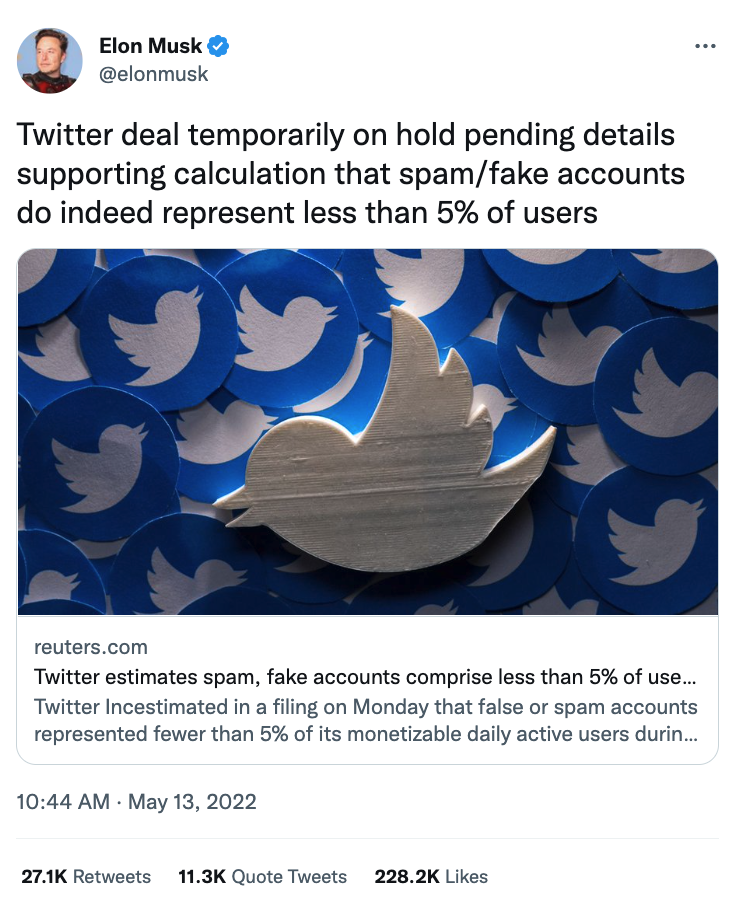 

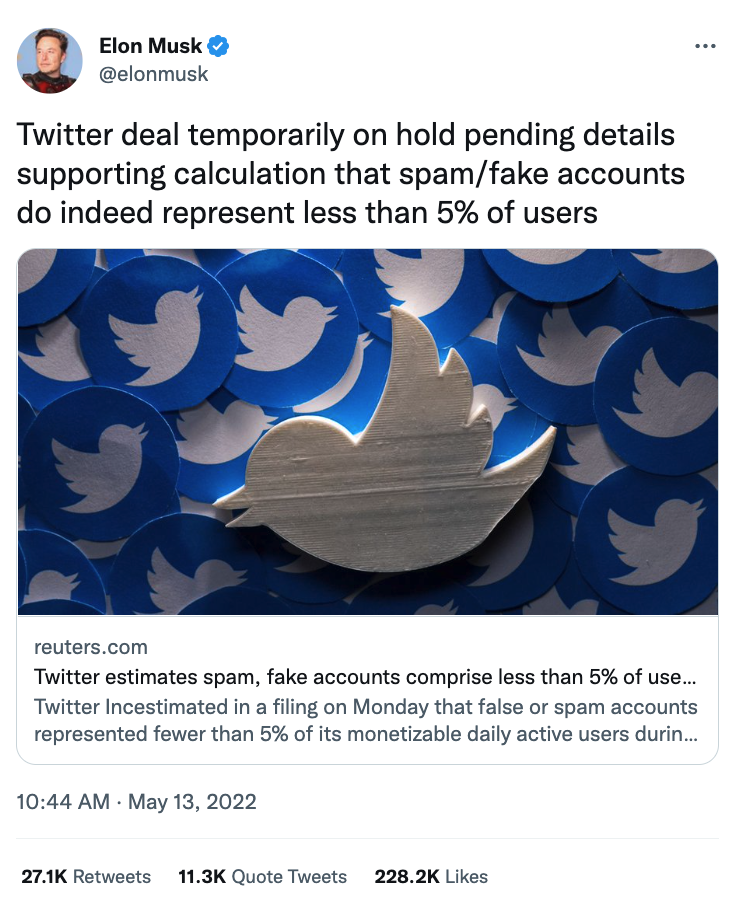

In [464]:
PATH = "/Users/peternolan/Documents/Post Grad/NCI/Courses/DAP/DAP Project/"
Image(filename = PATH + "20220513elonmusk.png", width=400, height=400)

In [108]:
# Identify the date and time of the tweet event to be analysed
tweet_datetime='2022-05-13 05:44'

## Graph the tweet date and time against stock movements
<a id='tweet-tests-graphs'></a>


### 1. Price (close)
### 2. Returns over 30 mins (returns_30min), 
### 3. Std dev of returns on 30 mins (stdev_30min)
### 4. Range over 30 mins (range_30mins)
### 5. Volume over 30 mins periods (volume_30mins)

In [160]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [161]:
events_tests(tweet_datetime, input_df, significance=0.05)

['2022-05-13 05:44',
 19.35399442406126,
 7.705993191657348e-20,
 0.05,
 'H_1: Mean different',
 1.9766121213429837,
 0.16746854326285865,
 'H_0: Variance same']

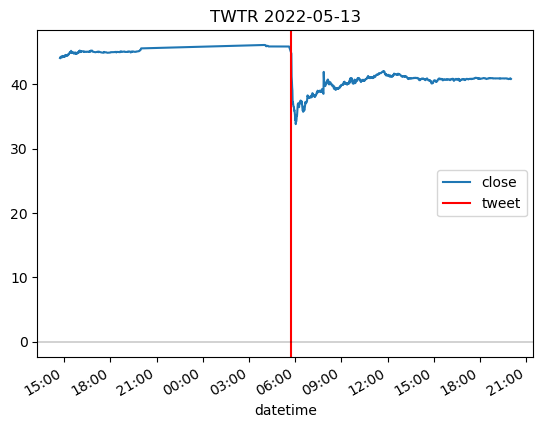

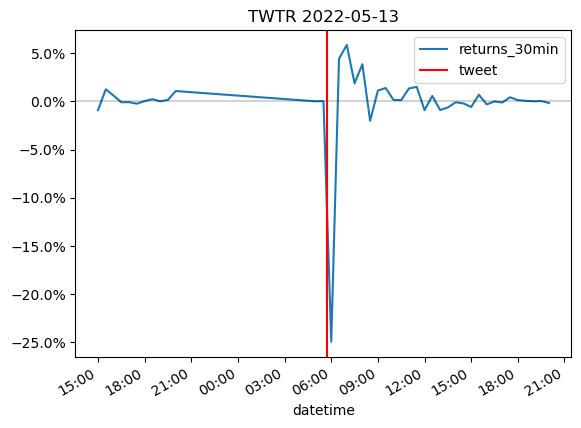

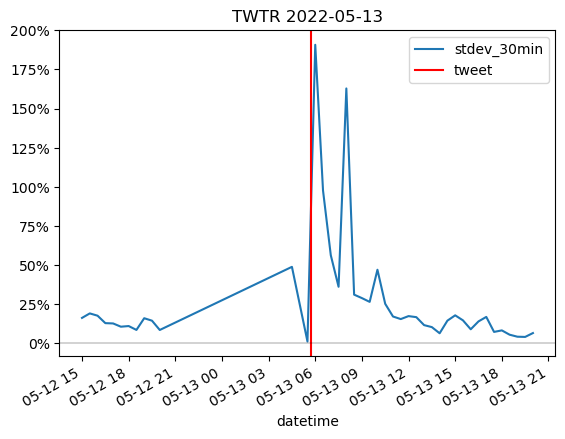

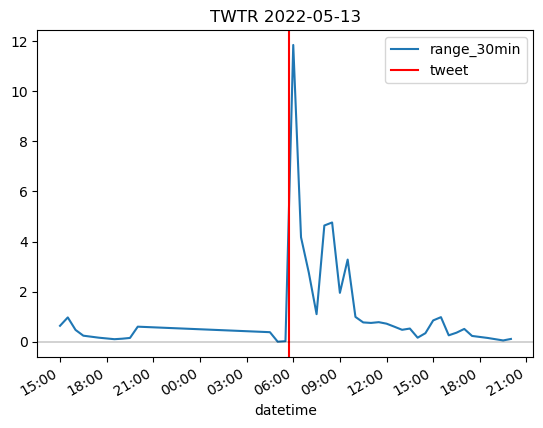

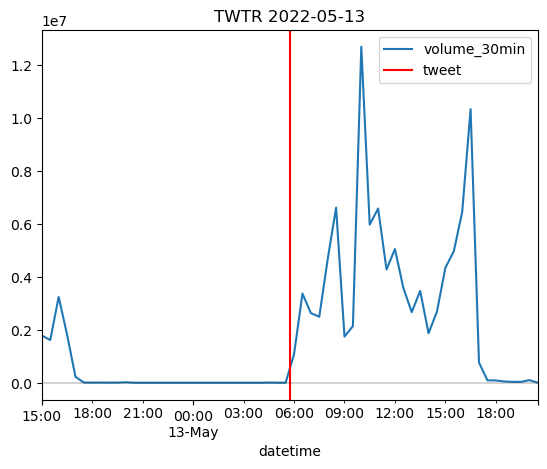

In [124]:
events_tests_graphs(tweet_datetime, input_df)

In [133]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [134]:
events_tests('2022-04-04 12:04',input_df, significance=0.05)

['2022-04-04 12:04',
 -8.81124555034454,
 4.0630626336068933e-07,
 0.05,
 'H_1: Mean different',
 7.5531884322872935,
 0.010742912963446441,
 'H_1: Variance different']

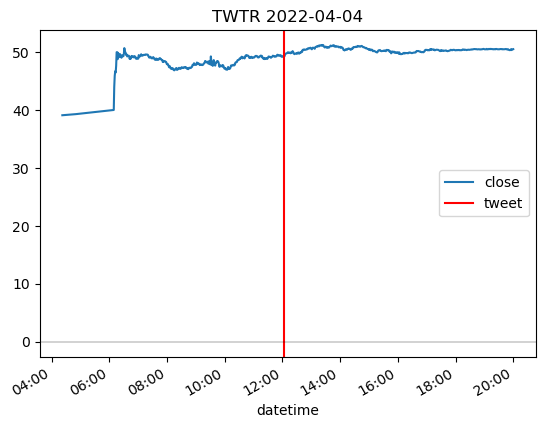

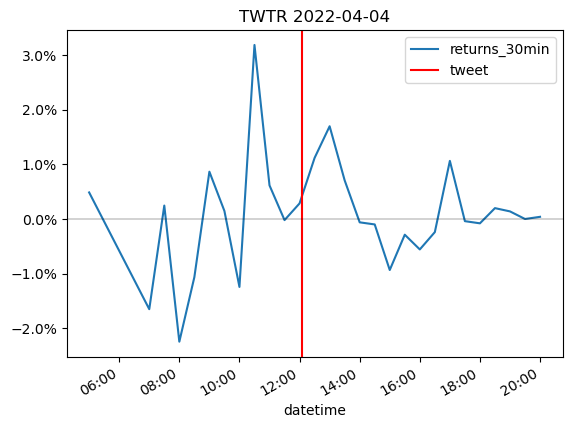

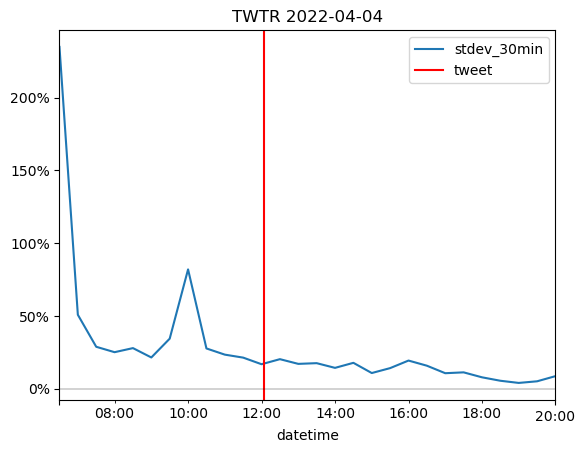

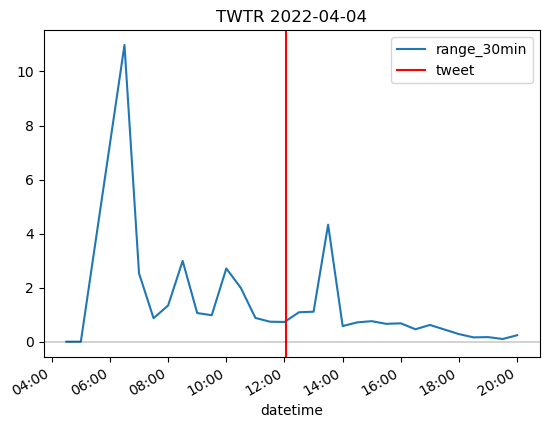

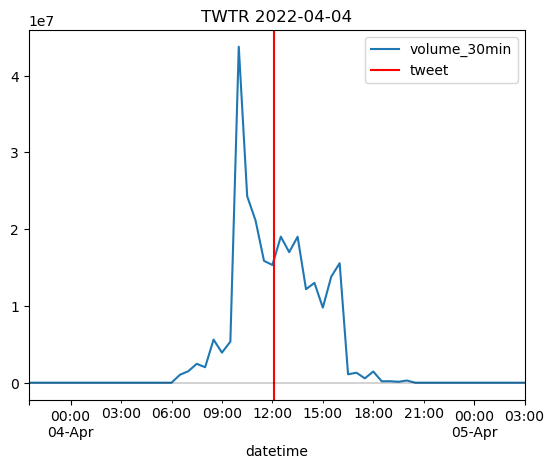

In [126]:
events_tests_graphs('2022-04-04 12:04',input_df)

In [135]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [136]:
events_tests('2022-04-14 07:23',input_df, significance=0.05)

['2022-04-14 07:23',
 7.511891721121172,
 7.897766927581869e-07,
 0.05,
 'H_1: Mean different',
 0.005895325425022963,
 0.9392114429017862,
 'H_0: Variance same']

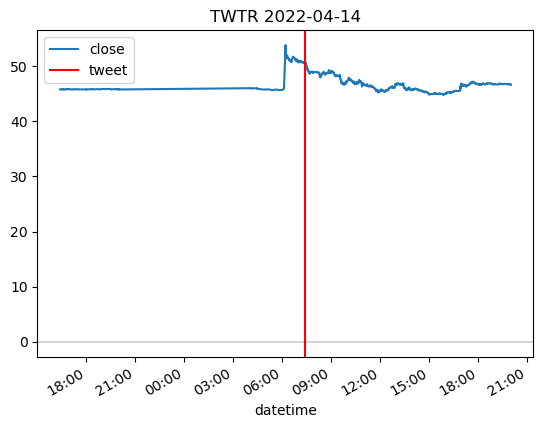

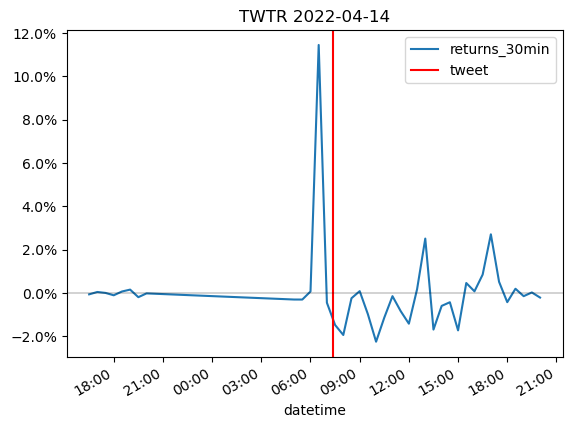

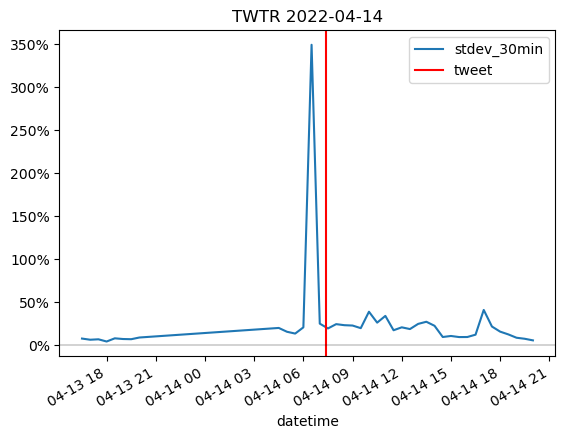

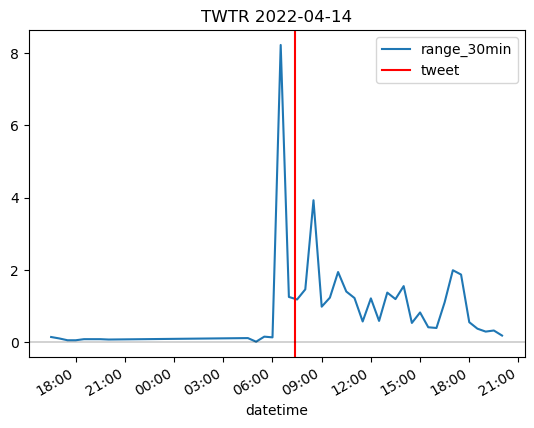

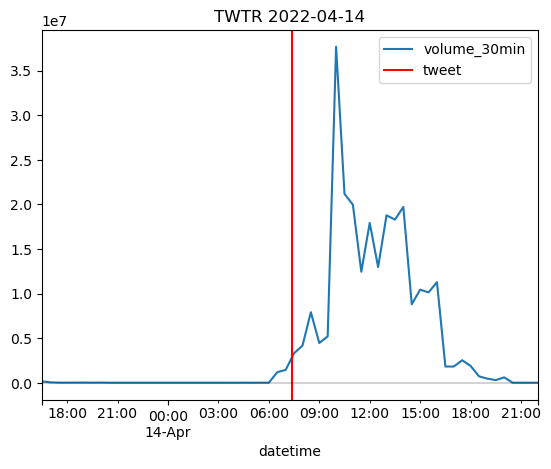

In [137]:
events_tests_graphs('2022-04-14 07:23',input_df)

In [138]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [139]:
events_tests('2022-04-21 14:53',input_df, significance=0.05)

['2022-04-21 14:53',
 -6.761437121791907,
 1.615924670839519e-07,
 0.05,
 'H_1: Mean different',
 6.561094510572499,
 0.015508529531763111,
 'H_1: Variance different']

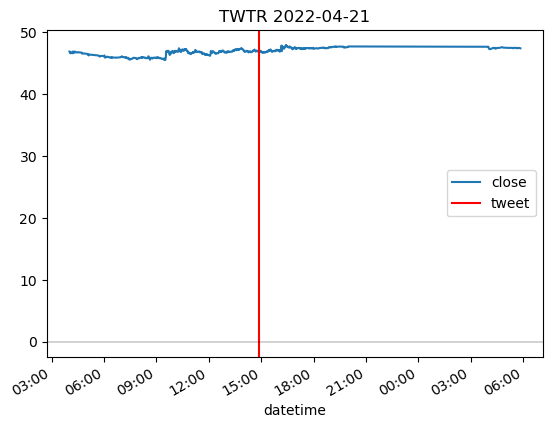

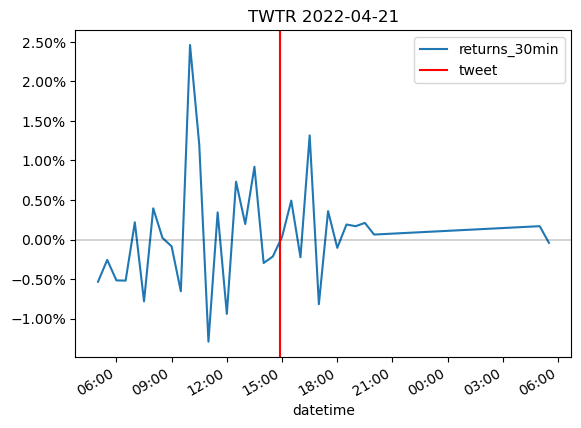

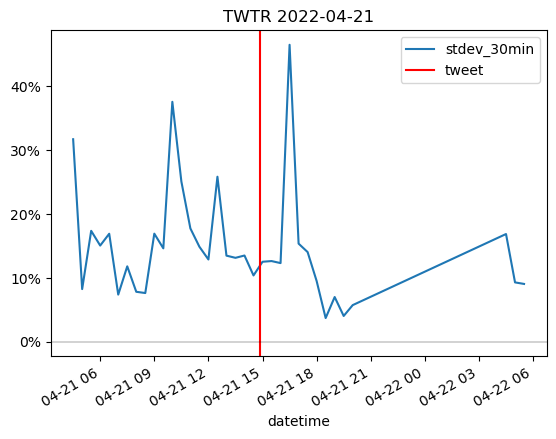

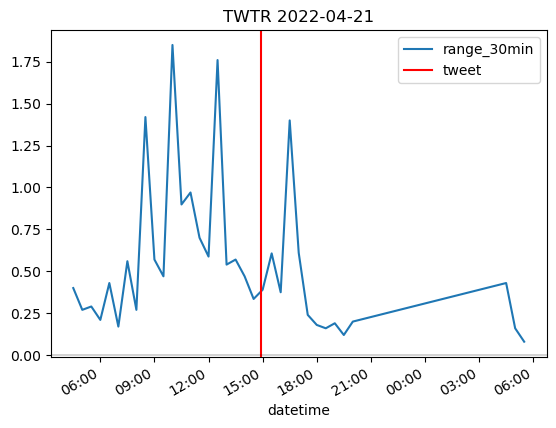

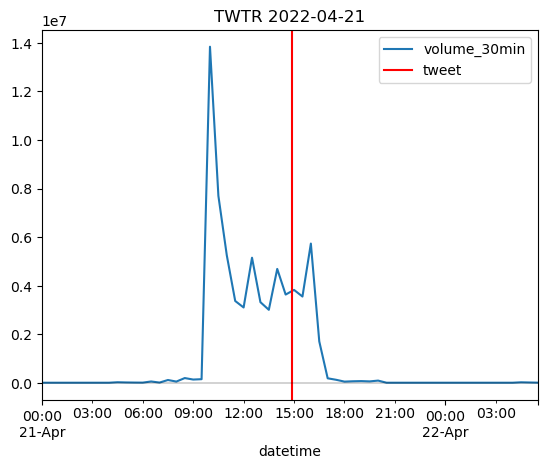

In [140]:
events_tests_graphs('2022-04-21 14:53',input_df)

In [144]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [145]:
events_tests('2022-04-25 15:43',input_df, significance=0.05)

['2022-04-25 15:43',
 5.576924390347736,
 1.410747895956641e-05,
 0.05,
 'H_1: Mean different',
 13.307405214354153,
 0.0009028536745085313,
 'H_1: Variance different']

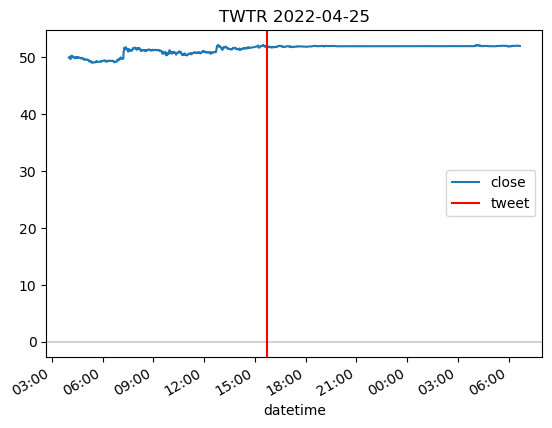

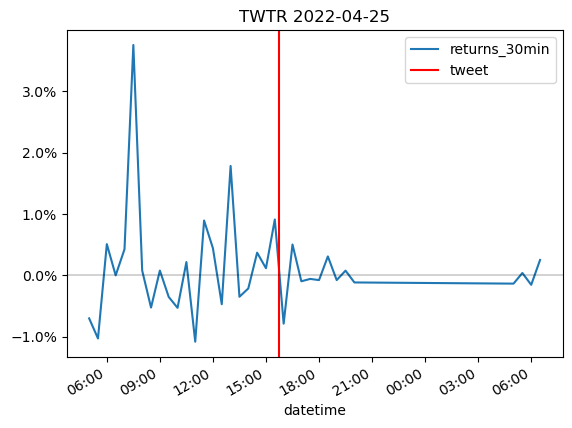

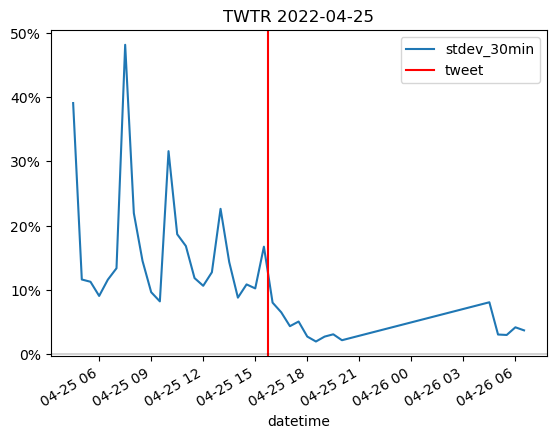

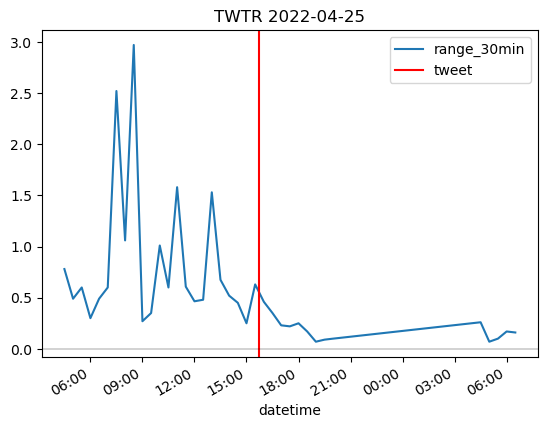

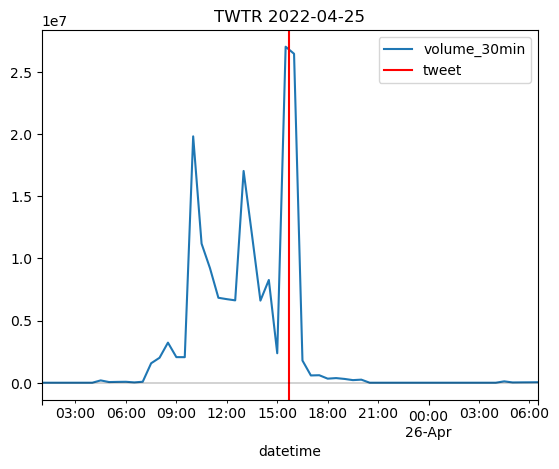

In [143]:
events_tests_graphs('2022-04-25 15:43',input_df)

In [109]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [146]:
events_tests('2022-05-05 09:14',input_df, significance=0.05)

['2022-05-05 09:14',
 -0.5556062454262224,
 0.5838542687493167,
 0.05,
 'H_0: Mean same',
 2.0153327582914926,
 0.16569558495795922,
 'H_0: Variance same']

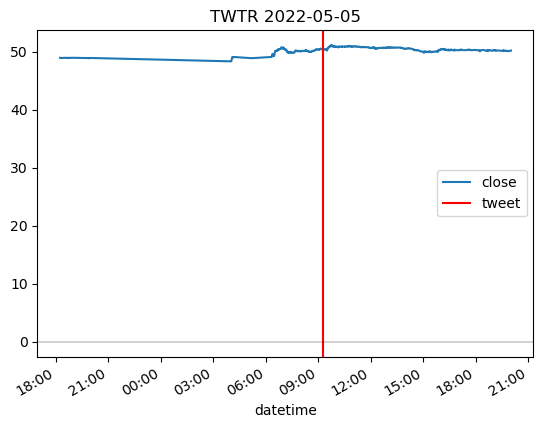

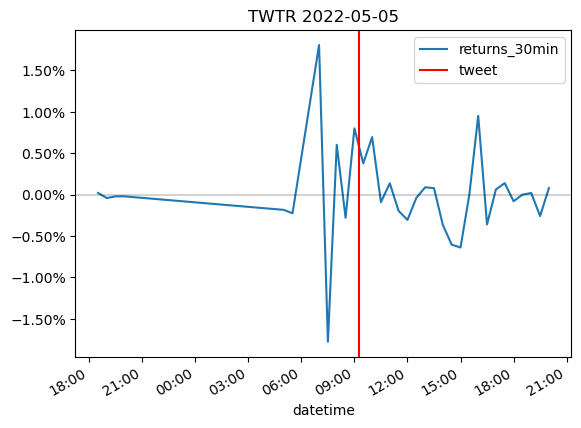

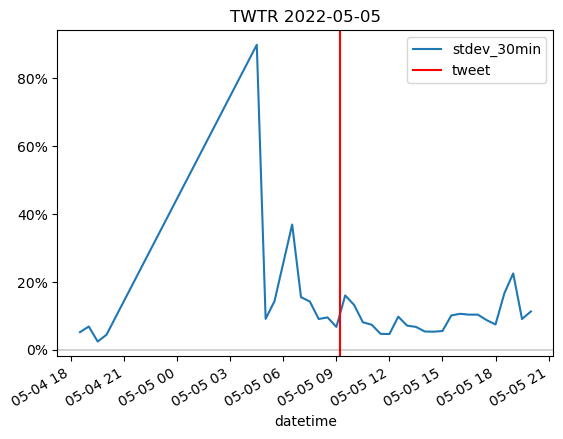

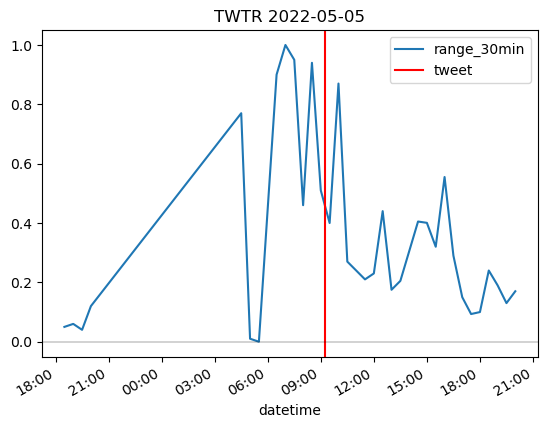

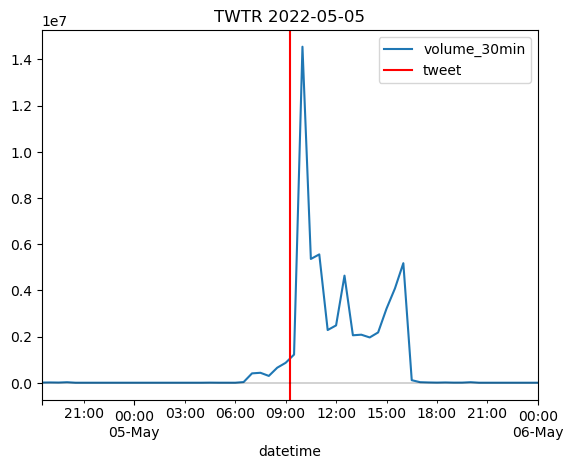

In [147]:
events_tests_graphs('2022-05-05 09:14',input_df)

In [148]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [149]:
events_tests('2022-05-13 05:44',input_df, significance=0.05)

['2022-05-13 05:44',
 19.35399442406126,
 7.705993191657348e-20,
 0.05,
 'H_1: Mean different',
 1.9766121213429837,
 0.16746854326285865,
 'H_0: Variance same']

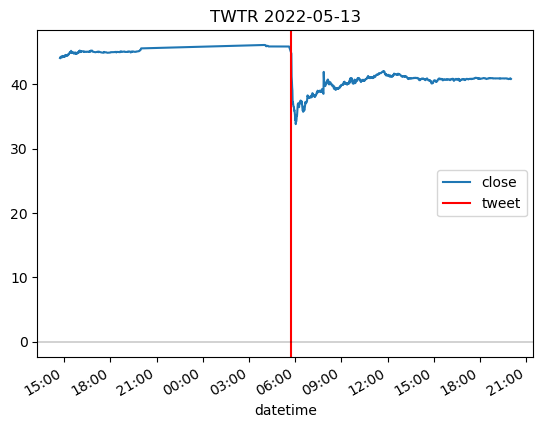

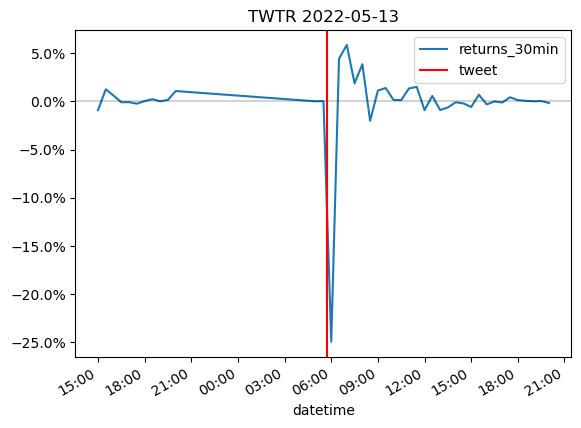

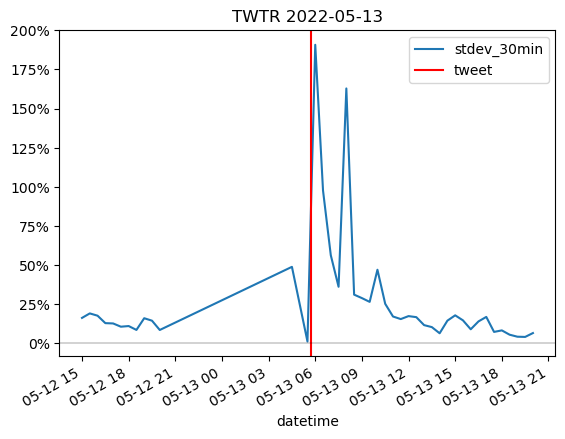

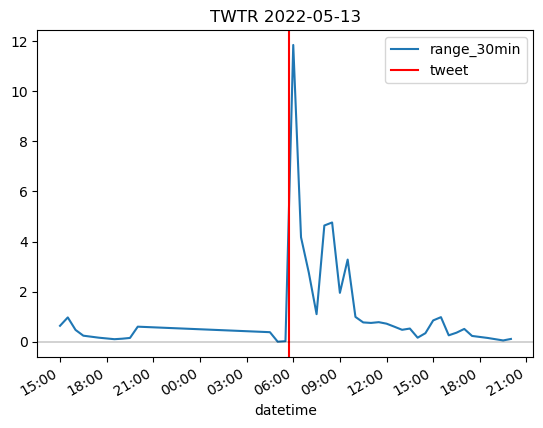

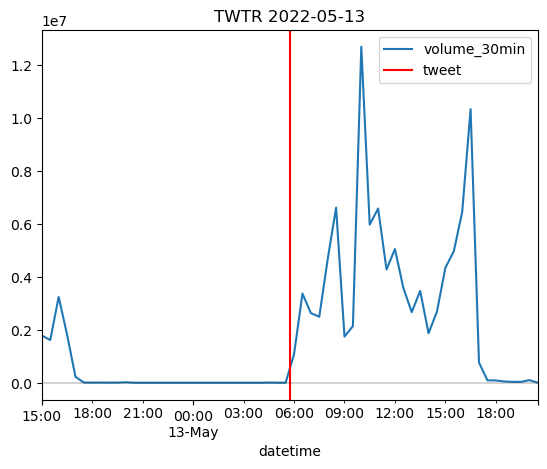

In [150]:
events_tests_graphs('2022-05-13 05:44',input_df)

In [151]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [152]:
 events_tests('2022-10-04 18:39', input_df, significance=0.05)

['2022-10-04 18:39',
 1.9512178135203353,
 0.06637959112675348,
 0.05,
 'H_0: Mean same',
 5.242502700978986,
 0.02950722327725084,
 'H_1: Variance different']

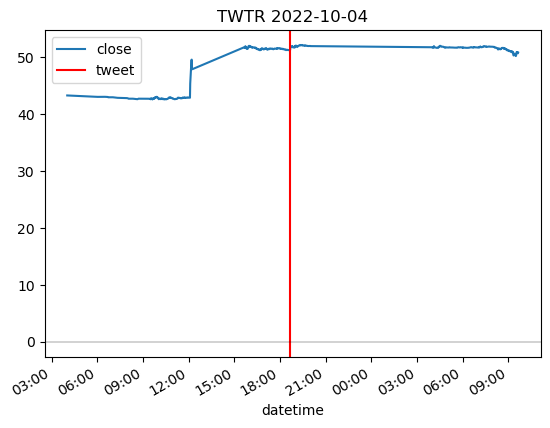

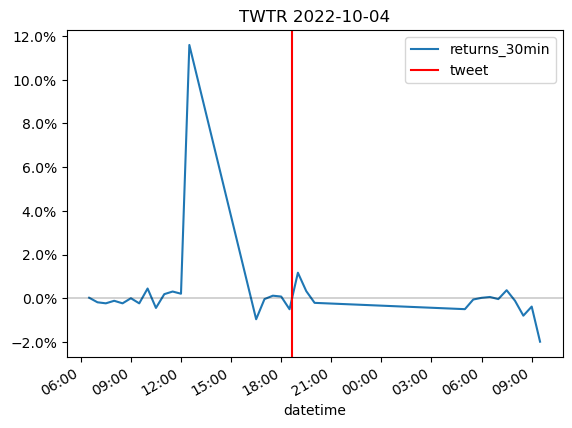

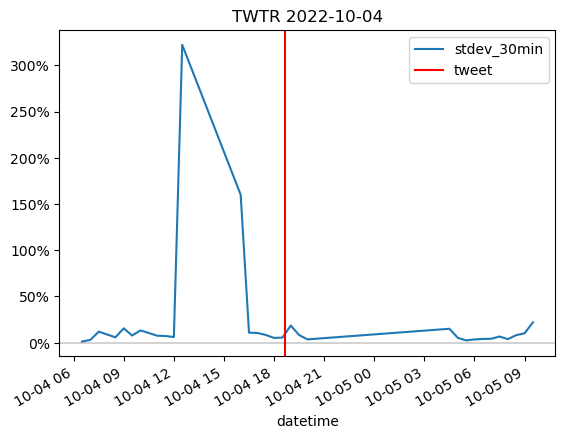

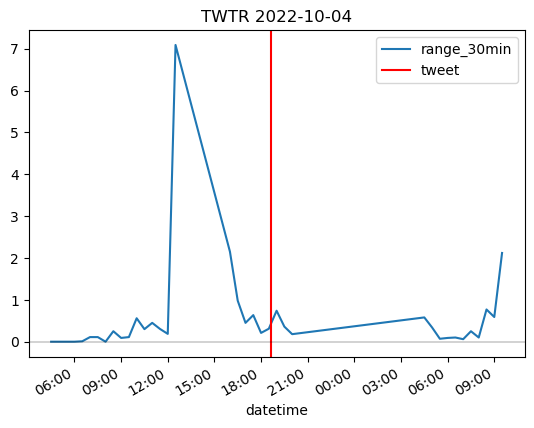

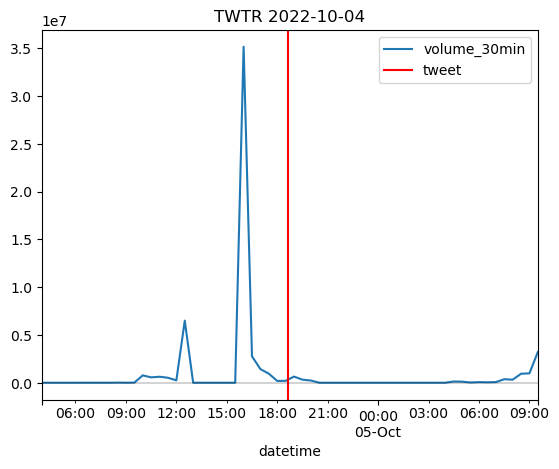

In [153]:
 events_tests_graphs('2022-10-04 18:39', input_df)

In [154]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [155]:
events_tests('2022-10-26 14:45',input_df, significance=0.05)

['2022-10-26 14:45',
 -7.078448202593095,
 3.034323206493429e-06,
 0.05,
 'H_1: Mean different',
 2.8627390888194646,
 0.10137275628283846,
 'H_0: Variance same']

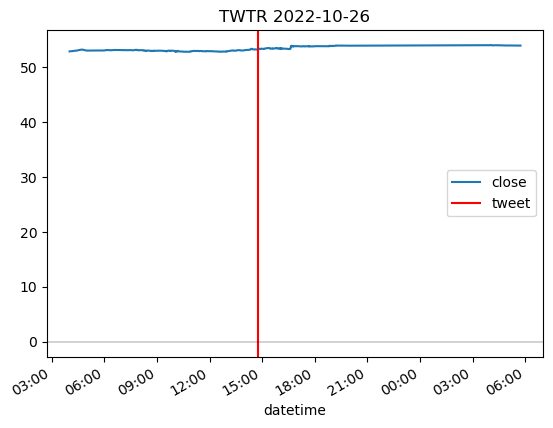

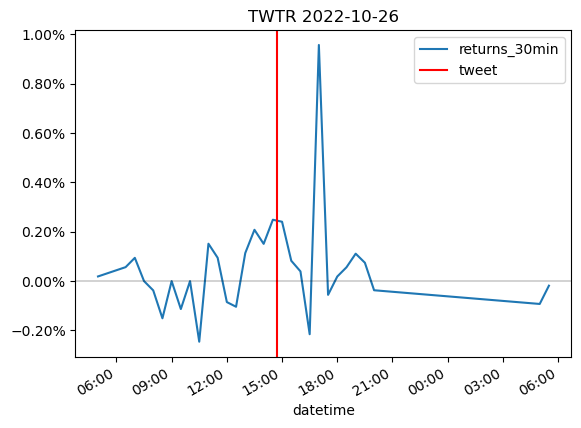

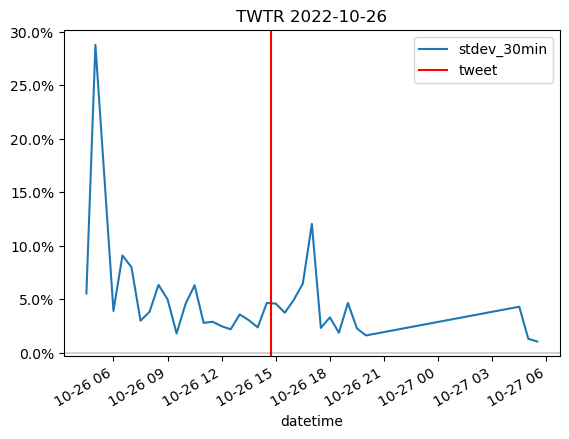

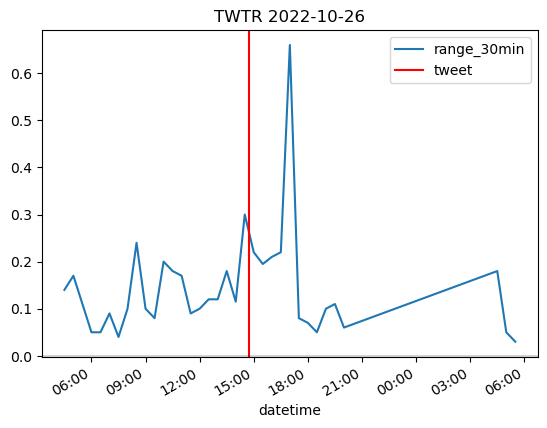

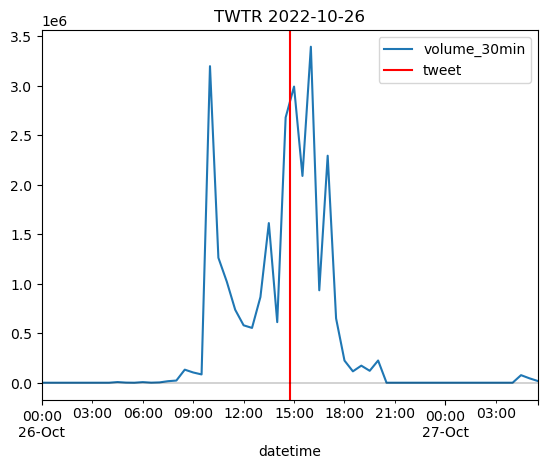

In [156]:
events_tests_graphs('2022-10-26 14:45',input_df)

In [157]:
print('tweet_datetime\n','t2_statistic\n', 't2_pvalue\n', 'significance\n', 'result1\n', 'levene_statistic\n', 
      'levene_pvalue\n', 'result2\n')

tweet_datetime
 t2_statistic
 t2_pvalue
 significance
 result1
 levene_statistic
 levene_pvalue
 result2



In [158]:
events_tests('2022-10-27 09:08',input_df, significance=0.05)

['2022-10-27 09:08',
 4.920197794099869,
 2.3389887293038064e-05,
 0.05,
 'H_1: Mean different',
 5.522841282898782,
 0.024900901911026885,
 'H_1: Variance different']

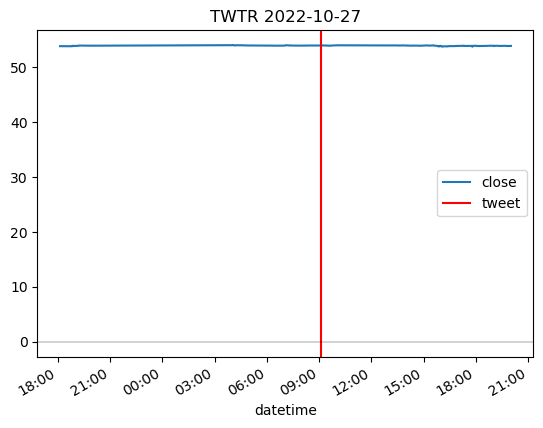

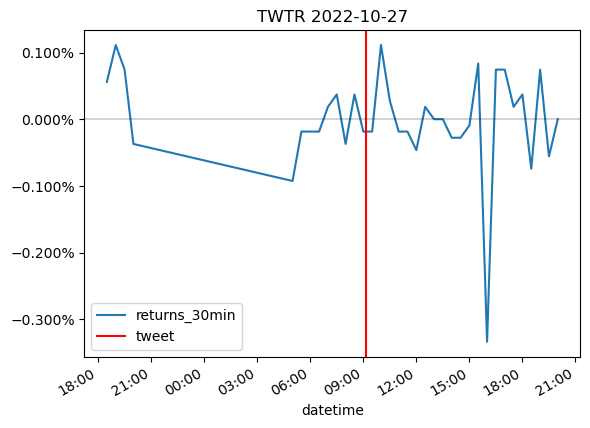

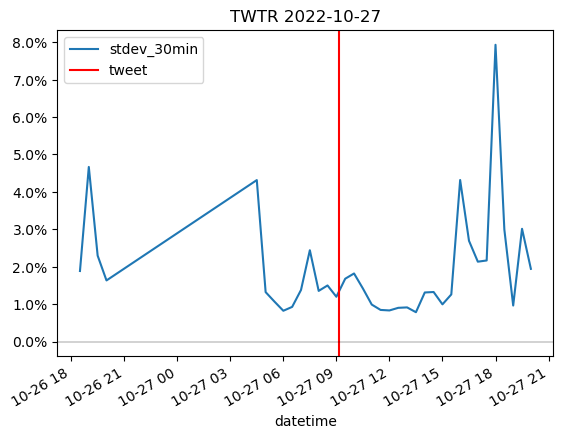

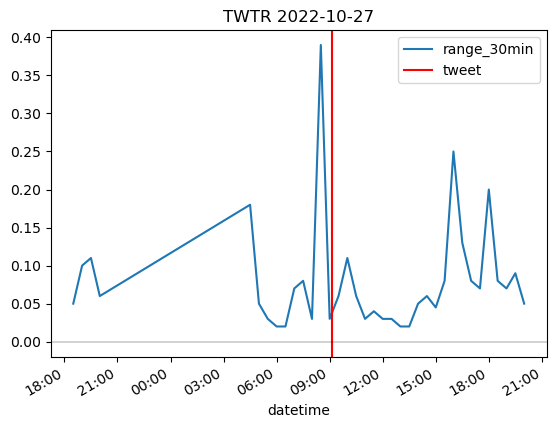

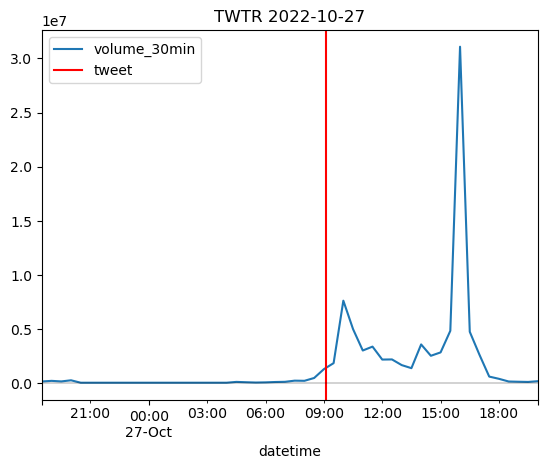

In [162]:
events_tests_graphs('2022-10-27 09:08',input_df)

## Event tests summary table
<a id='test-summary-table'></a>


In [163]:
tweet_times=[
'2022-3-25 02:34',
'2022-4-4 12:04',
'2022-4-14 07:23',
'2022-4-21 14:53',
'2022-4-25 15:43',
'2022-5-5 09:14',
'2022-5-13 05:44',
'2022-10-4 18:39',
'2022-10-26 14:45',
'2022-10-27 09:08'
]

In [164]:
t_tests_results= []

In [114]:
for i in range(0,len(tweet_times)):
    t_tests_results.append(events_tests(tweet_times[i], input_df))

In [115]:
events_tests_results=pd.DataFrame(columns=['tweet_datetime','t2_statistic', 't2_pvalue', 'significance', 'result1', \
                                     'levene_statistic', 'levene_pvalue', 'result2'])

In [116]:
# t_tests_results

In [506]:
stock_df.columns

Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'returns_1min',
       'returns_30min', 'returns_1d', 'volume_30min', 'volume_1d',
       'stdev_30min', 'stdev_1d', 'range_1min', 'range_30min', 'range_1d'],
      dtype='object')

In [117]:
for i in t_tests_results:
    events_tests_results.loc[len(events_tests_results)]=i

In [122]:
events_tests_results.style.set_properties(**{'text-align': 'left'})

,tweet_datetime,t2_statistic,t2_pvalue,significance,result1,levene_statistic,levene_pvalue,result2
0,2022-3-25 02:34,-0.159318,0.874648,0.050000,H_0: Mean same,27.114885,0.000007,H_1: Variance different
1,2022-4-4 12:04,-8.811246,0.000000,0.050000,H_1: Mean different,7.553188,0.010743,H_1: Variance different
2,2022-4-14 07:23,7.511892,0.000001,0.050000,H_1: Mean different,0.005895,0.939211,H_0: Variance same
3,2022-4-21 14:53,-6.761437,0.000000,0.050000,H_1: Mean different,6.561095,0.015509,H_1: Variance different
4,2022-4-25 15:43,5.576924,0.000014,0.050000,H_1: Mean different,13.307405,0.000903,H_1: Variance different
5,2022-5-5 09:14,-0.555606,0.583854,0.050000,H_0: Mean same,2.015333,0.165696,H_0: Variance same
6,2022-5-13 05:44,19.353994,0.000000,0.050000,H_1: Mean different,1.976612,0.167469,H_0: Variance same
7,2022-10-4 18:39,1.951218,0.066380,0.050000,H_0: Mean same,5.242503,0.029507,H_1: Variance different
8,2022-10-26 14:45,-7.078448,0.000003,0.050000,H_1: Mean different,2.862739,0.101373,H_0: Variance same
9,2022-10-27 09:08,4.920198,0.000023,0.050000,H_1: Mean different,5.522841,0.024901,H_1: Variance different


In [505]:
save_df(events_tests_results,"events_tests_results"  )

events_tests_results_2022_12_13_45.csv


# Testing Twitter and Reddit Sentiment
<a id='test-twitter-reddit'></a>

Test polarity scores for tweets and posts, both means and the standard deviation of polarity scores calculated by date, against the daily stock returns and standard deviations

Read the upload file

In [467]:
twitter_df=pd.read_csv('twitter_aggregates.csv')

In [329]:
# inspect visually
twitter_df

,date,twitter_mean_1d,twitter_stdev_1d
0,2022-03-01,0.14408,0.358286
1,2022-03-02,0.18955,0.381565
2,2022-03-03,0.13239,0.304115
3,2022-03-04,0.12526,0.544260
4,2022-03-05,0.30681,0.342899
...,...,...,...
218,2022-11-06,0.02174,0.435067
219,2022-11-07,0.12599,0.314726
220,2022-11-08,0.23316,0.348535
221,2022-11-09,0.24051,0.443586


Clean the Twitter polarity data file by adding datetime as an index and cutting to match the test dates of 5 April to 10 October 2022

In [330]:
twitter_dates=pd.to_datetime(pd.to_datetime(twitter_df['date'])) 
twitter_df.insert(0,column='datetime',value=twitter_dates)
twitter_df=twitter_df.set_index('datetime')
twitter_df=twitter_df['2022-04-05':'2022-10-27']

In [331]:
twitter_df

,date,twitter_mean_1d,twitter_stdev_1d
datetime,,,
2022-04-06,2022-04-06,0.25073,0.322256
2022-04-07,2022-04-07,0.20261,0.325296
2022-04-08,2022-04-08,0.23620,0.341435
2022-04-09,2022-04-09,-0.02977,0.282983
2022-04-10,2022-04-10,-0.09483,0.388436
...,...,...,...
2022-10-23,2022-10-23,0.12805,0.227468
2022-10-24,2022-10-24,0.19479,0.442259
2022-10-25,2022-10-25,0.12948,0.250972


Retrieve stock returns

In [332]:
sample_returns=stock_df['returns_1d']['2022-04-05':'2022-10-27'].dropna()

In [333]:
sample_returns

datetime
2022-04-05    0.012470
2022-04-06   -0.009775
2022-04-07   -0.056269
2022-04-08   -0.031381
2022-04-11    0.008207
                ...   
2022-10-21   -0.044759
2022-10-24    0.041450
2022-10-25    0.015766
2022-10-26    0.020254
2022-10-27   -0.000742
Name: returns_1d, Length: 143, dtype: float64

In [334]:
sample_returns.index

DatetimeIndex(['2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08',
               '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14',
               '2022-04-18', '2022-04-19',
               ...
               '2022-10-14', '2022-10-17', '2022-10-18', '2022-10-19',
               '2022-10-20', '2022-10-21', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27'],
              dtype='datetime64[ns]', name='datetime', length=143, freq=None)

Add stock returns to Twitter dataframe

In [335]:

twitter_df=twitter_df.merge(sample_returns,how='left',left_index=True,right_index=True,sort=True,validate='one_to_one')
    

Retrieve daily 1min stock returns standard deviation

In [336]:
 sample_stdev=stock_df['stdev_1d']['2022-04-05':'2022-10-27'].dropna()

Add stock std dev to Twitter dataframe

In [337]:
twitter_df=twitter_df.merge(sample_stdev,how='left',left_index=True,right_index=True,sort=True,validate='one_to_one')
    

In [338]:
twitter_df

,date,twitter_mean_1d,twitter_stdev_1d,returns_1d,stdev_1d
datetime,,,,,
2022-04-06,2022-04-06,0.25073,0.322256,-0.009775,0.029623
2022-04-07,2022-04-07,0.20261,0.325296,-0.056269,0.027811
2022-04-08,2022-04-08,0.23620,0.341435,-0.031381,0.031005
2022-04-09,2022-04-09,-0.02977,0.282983,NaN,NaN
2022-04-10,2022-04-10,-0.09483,0.388436,NaN,NaN
...,...,...,...,...,...
2022-10-23,2022-10-23,0.12805,0.227468,NaN,NaN
2022-10-24,2022-10-24,0.19479,0.442259,0.041450,0.014651
2022-10-25,2022-10-25,0.12948,0.250972,0.015766,0.012753


Drop NA values, as many days did not have a tweet or Reddit post we could retrieve

In [339]:
twitter_df.isna().sum()

date                 0
twitter_mean_1d      0
twitter_stdev_1d     0
returns_1d          54
stdev_1d            54
dtype: int64

In [340]:
twitter_df=twitter_df.dropna()

In [341]:
twitter_df.isna().sum()

date                0
twitter_mean_1d     0
twitter_stdev_1d    0
returns_1d          0
stdev_1d            0
dtype: int64

In [342]:
twitter_df

,date,twitter_mean_1d,twitter_stdev_1d,returns_1d,stdev_1d
datetime,,,,,
2022-04-06,2022-04-06,0.25073,0.322256,-0.009775,0.029623
2022-04-07,2022-04-07,0.20261,0.325296,-0.056269,0.027811
2022-04-08,2022-04-08,0.23620,0.341435,-0.031381,0.031005
2022-04-14,2022-04-14,0.21587,0.305304,0.018777,0.103085
2022-04-18,2022-04-18,0.27473,0.316064,0.045864,0.030908
...,...,...,...,...,...
2022-10-21,2022-10-21,0.14200,0.409901,-0.044759,0.062833
2022-10-24,2022-10-24,0.19479,0.442259,0.041450,0.014651
2022-10-25,2022-10-25,0.12948,0.250972,0.015766,0.012753


### Regress y= 1d stock returns against x= 1d Twitter mean polarity score

In [343]:
slope, intercept, r_value, p_value, std_err = \
stats.linregress(twitter_df['twitter_mean_1d'],twitter_df['returns_1d'])

In [344]:
print("r_value={:.4f}, p_value={:.4%}".format(r_value,p_value))

r_value=0.1154, p_value=20.1704%


In [345]:
print("R squared = {:.4%}".format(r_value**2))

R squared = 1.3326%


No significant R squared and probability value looks too high to be a rejection of the null hypothesis that the coefficients are all zero. We accept H_0, so there is likely no relationship.

### Regress y=1d stock returns against x= 1d Twitter standard deviation of polarity score

In [346]:
slope, intercept, r_value, p_value, std_err = \
stats.linregress(twitter_df['twitter_stdev_1d'],twitter_df['returns_1d'])

In [347]:
print("r_value={:.4f}, p_value={:.4%}".format(r_value,p_value))

r_value=0.3027, p_value=0.0634%


In [348]:
print("R squared = {:.4%}".format(r_value**2))

R squared = 9.1610%


R squared is low even though probability value looks low enough to be a rejection of the null hypothesis that the coefficients are all zero. We reject H_0, so there is likely some relationship.

### Regress y=1d stock std dev against x = 1d Twitter standard deviation of polarity score

In [349]:
slope, intercept, r_value, p_value, std_err = \
stats.linregress(twitter_df['twitter_stdev_1d'],twitter_df['stdev_1d'])

In [350]:
print("r_value={:.4f}, p_value={:.4%}".format(r_value,p_value))

r_value=0.1940, p_value=3.0876%


In [351]:
print("R squared = {:.4%}".format(r_value**2))

R squared = 3.7626%


No significant R squared and probability value looks too high to be a rejection of the null hypothesis that the coefficients are all zero. We accept H_0, so there is likely no relationship.

# Reddit sensitivity

Read the upload file

In [428]:
reddit_df=pd.read_csv('reddit_aggregates.csv')

In [429]:
reddit_df

,datetime,stdev_1d,returns_1d,stdev_pol_1d,mean_pol_1d
0,2022-10-27,0.004173,-0.000742,0.460787,0.075319
1,2022-10-26,0.008483,0.020254,NaN,NaN
2,2022-10-25,0.012753,0.015766,NaN,NaN
3,2022-10-24,0.014651,0.041450,NaN,NaN
4,2022-10-21,0.062833,-0.044759,NaN,NaN
...,...,...,...,...,...
138,2022-04-11,0.051493,0.008207,0.471323,-0.075932
139,2022-04-08,0.031005,-0.031381,NaN,NaN
140,2022-04-07,0.027811,-0.056269,NaN,NaN
141,2022-04-06,0.029623,-0.009775,NaN,NaN


In [430]:
#reddit_dates=pd.to_datetime(pd.to_datetime(reddit_df['datetime'])) 
#reddit_df.insert(0,column='datetime',value=reddit_dates)
reddit_df=reddit_df.set_index('datetime')
#reddit_df=reddit_df['2022-04-05':'2022-10-27']


In [431]:
reddit_df

,stdev_1d,returns_1d,stdev_pol_1d,mean_pol_1d
datetime,,,,
2022-10-27,0.004173,-0.000742,0.460787,0.075319
2022-10-26,0.008483,0.020254,NaN,NaN
2022-10-25,0.012753,0.015766,NaN,NaN
2022-10-24,0.014651,0.041450,NaN,NaN
2022-10-21,0.062833,-0.044759,NaN,NaN
...,...,...,...,...
2022-04-11,0.051493,0.008207,0.471323,-0.075932
2022-04-08,0.031005,-0.031381,NaN,NaN
2022-04-07,0.027811,-0.056269,NaN,NaN


In [437]:
reddit_df=reddit_df.dropna()

Inspect visually

In [438]:
reddit_df

,stdev_1d,returns_1d,stdev_pol_1d,mean_pol_1d
datetime,,,,
2022-10-27,0.004173,-0.000742,0.460787,0.075319
2022-10-17,0.010008,0.004951,0.481258,0.148733
2022-10-06,0.028515,-0.049814,0.428616,-0.033748
2022-10-05,0.019542,-0.019423,0.502581,0.173710
2022-10-04,0.107042,0.224105,0.368286,0.036328
2022-08-09,0.038897,-0.001864,-0.532736,-0.183331
2022-08-08,0.017047,0.007277,-0.414333,0.143013
2022-07-25,0.018475,-0.019593,0.659761,0.273717
2022-07-19,0.022952,0.032941,0.515959,0.145778


Regress y=1d stock returns against x= 1d Reddit mean of polarity score

In [441]:
slope, intercept, r_value, p_value, std_err = \
stats.linregress(reddit_df['mean_pol_1d'],reddit_df['returns_1d'])

In [442]:
print("r_value={:.4f}, p_value={:.4%}".format(r_value,p_value))

r_value=-0.0970, p_value=53.6264%


In [443]:
print("R squared = {:.4%}".format(r_value**2))

R squared = 0.9399%


No significant R squared and probability value looks too high to be a rejection of the null hypothesis that the coefficients are all zero. We accept H_0, so there is likely no relationship.

Regress y=1d stock returns against x= 1d Reddit standard deviation of polarity score

In [444]:
slope, intercept, r_value, p_value, std_err = \
stats.linregress(reddit_df['stdev_pol_1d'],reddit_df['returns_1d'])

In [445]:
print("r_value={:.4f}, p_value={:.4%}".format(r_value,p_value))

r_value=0.0734, p_value=63.9919%


In [446]:
print("R squared = {:.4%}".format(r_value**2))

R squared = 0.5389%


No significant R squared and probability value looks too high to be a rejection of the null hypothesis that the coefficients are all zero. We accept H_0, so there is likely no relationship.

Regress y=1d stock standard deviation of returns against x= 1d Reddit standard deviation of polarity score

In [447]:
slope, intercept, r_value, p_value, std_err = \
stats.linregress(reddit_df['stdev_pol_1d'],reddit_df['stdev_1d'])

In [448]:
print("r_value={:.4f}, p_value={:.4%}".format(r_value,p_value))

r_value=-0.0484, p_value=75.8017%


In [449]:
print("R squared = {:.4%}".format(r_value**2))

R squared = 0.2341%


No significant R squared and probability value looks too high to be a rejection of the null hypothesis that the coefficients are all zero. We accept H_0, so there is likely no relationship.

# Descriptive Statistics

In [474]:
stock_df['2022-10-27']['close'].dropna().mean()

/var/folders/c8/rb2x8dkj5pjcsshh_0pbkd_h0000gn/T/ipykernel_42378/2363622164.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  stock_df['2022-10-27']['close'].dropna().mean()


53.91234469339616

In [ ]:
ohlc_30min=input_df['close'].resample("30min",closed='right',label='right').ohlc() # OHLC prices every 30 mins
    

In [477]:
stock_df['close'].dropna()

datetime
2021-12-17 04:15:00    42.83
2021-12-17 04:16:00    42.68
2021-12-17 04:17:00    42.60
2021-12-17 04:18:00    42.60
2021-12-17 04:27:00    42.73
                       ...  
2022-10-27 19:56:00    53.85
2022-10-27 19:57:00    53.86
2022-10-27 19:58:00    53.86
2022-10-27 19:59:00    53.86
2022-10-27 20:00:00    53.86
Name: close, Length: 124647, dtype: float64

In [483]:
mean_daily_price=stock_df['close'].dropna().resample("1d",closed='right',label='right').mean() # OHLC prices every 30 mins

In [488]:
mean_daily_price=stock_df['close'].resample("1d",closed='right',label='right').mean() # OHLC prices every 30 mins

In [498]:
mean_daily_price.index[315]

Timestamp('2022-10-28 00:00:00', freq='D')

In [491]:
mean_daily_price.argmax()

315

In [490]:
mean_daily_price.max()

53.91234469339622

<AxesSubplot:xlabel='datetime'>

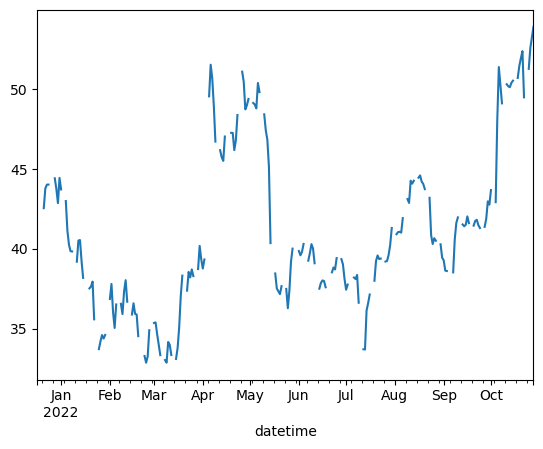

In [499]:
mean_daily_price.plot()

In [503]:
print('{:.3%}'.format(53.91/54.2))

99.465%
